# ITTT: IT Term Translation System
---
ITTT는 영어로 된 IT 용어에 대한 설명을 한국어로 번역하는 모델입니다.<br>

모델 정보는 다음과 같습니다.<br>

Base Model
- `yanolja`의 `EEVE-Korean-2.8B-v1.0`
<br>

Data 
- TTA 한국정보통신기술협회의 정보통신용어사전에 수록되어 있는 IT 단어(2021~2023년도)를 ChatGPT를 통해 영어 설명, 한국어 번역 제작
- 허깅페이스 업로드 완료 [[허깅페이스 링크]](https://huggingface.co/datasets/bkk21/TranslationData300)
- 사용 코드 `load_dataset("bkk21/TranslationData300")`
<br>

Train
- QLoRA
- task_type = `SEQ2SEQ_LM`
- r = `8` (차원)
- lora_alpha = `32` (스케일링)
- lora_dropout = `0.05` (드롭아웃)
- batch_size = `2` (배치사이즈)
- step = `500` (스텝)
- learningrate = `1e-4` (러닝 레이트)
<br>

Test
- BLEU Score 계산
- 사용자 평가

## Libraries
---
설치 및 import 진행

In [1]:
#gpu 확인
!nvidia-smi

Fri Jul 19 13:15:22 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   25C    P0             50W /  400W |   13423MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
#파이썬 버전 확인
!python -V

Python 3.10.12


In [3]:
#torch 버전 확인
import torch

print(torch.__version__)

2.3.0+cu121


In [4]:
#패키지 설치
!pip install -q pyarrow==14.0.1
!pip install -q datasets==2.18.0
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git #transformers 설치
!pip install -q -U git+https://github.com/huggingface/peft.git #peft 설치
!pip install -q -U git+https://github.com/huggingface/accelerate.git #accelerate 설치
!pip install -q accelerate #accelerate 설치
!pip install -q deepl #deepl 설치
%pip install -q konlpy #konlpy 설치

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [96]:
#기본 import
from datasets import load_dataset, Dataset, load_from_disk
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model
import transformers
import re
import pandas as pd
import os
import json
import datasets
import deepl
from nltk.translate.bleu_score import sentence_bleu
from konlpy.tag import Okt

## Base Model
---
Base Model은 `yanolja`의 `EEVE-Korean-2.8B-v1.0`를 사용했으며, 이유는 다음과 같습니다.

1. 한국어로 번역을 하고 답을 해야하므로, 답변의 퀄리티를 위해서는 한국어를 잘 할 줄 아는 모델일 것.
2. 모델의 크기가 7B 이하일 것.

llama2에 한국어를 학습한 ko-llama를 포함하여 한국어를 잘 한다고 알려진 모델을 사용해보았었는데, EEVE 모델이 가장 좋은 답변을 했었던 기억이 있습니다. 또한, eeve는 2.8B 크기의 모델도 갖고 있어 이번 프로젝트에 적합하다고 생각하였습니다.
<br><br>
The base model is `EEVE-Korean-2.8B-v1.0` by `yanolja`, and the reasons are as follows

1. the model must be able to translate and answer in Korean, so the model must be good at Korean for the quality of the answers.
2. the size of the model should be 7B or less.

I tried using models that are known to be good at Korean, including ko-llama, which was trained on llama2, but I remember that the EEVE model gave the best answers. Also, EEVE has a model with a size of 2.8B, so I thought it was suitable for this project.

In [6]:
#base model 불러오기 - EEVE-Korean-2.8B-v1.0

tokenizer = AutoTokenizer.from_pretrained("yanolja/EEVE-Korean-2.8B-v1.0", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("yanolja/EEVE-Korean-2.8B-v1.0", device_map={"":'cuda'})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Test Mase Model
---
base model을 사용했을 때 프롬프트는 지시, 문맥,답변으로 템플릿을 구성하였고, 다음과 같습니다. <br><br>
`###instruction: {system}\n\n### input: {x}\n\n### output:`<br>
- system은 지시를 의미하며, `입력된 영어 문장을 한국어로 번역하세요.`를 사용했습니다.<br>
- x는 문맥을 의미하며 번역할 문장을 사용했습니다.<br>

base model의 결과는 번역과는 매우 거리가 먼 답변이 나왔습니다. 문장에 대한 번역을 하는 것이 아닌, WebRTC에 대한 추가적인 설명이 있었으며, 심지어 초반에는 영어로 답변을 했었습니다. <br>

결과적으로 base model은 번역을 해야 한다는 문장의 의미를 이해하지 못하여 번역 model로써는 실패한 모델이라고 생각하며, 영어에서 한국어로 번역을 하는 것과 자연스럽게 번역을 하는 데이터를 학습해야 겠다고 생각하였습니다.<br>

평가를 위해서 훈련에서도 동일한 프롬프트 구성을 사용했습니다.<br>
<br><br>
When we used the base model, the prompt was templated with a directive, context, and answer, and looked like this <br><br>
`###instruction: {system}\n\n### input: {x}\n\n### output:`<br>
- system means instruction, and we used `Translate the input English sentence into Korean`.<br>
- x means context, and we used the sentence to be translated.<br>

The result of the base model was a very far cry from translation: instead of translating the sentence, there was an additional explanation of WebRTC, and even the initial answer was in English. <br>

As a result, the base model did not understand the meaning of the sentence to be translated, so I think it is a failed model as a translation model, and I think we need to learn data that translates naturally from English to Korean.<br>

For evaluation, we used the same prompt configuration in training.

In [7]:
#model 사용함수 정의
def gen(x):
  system = "입력된 영어 문장을 한국어로 번역하세요."
  gened = model.generate(
      **tokenizer(
          f"###instruction: {system}\n\n### input: {x}\n\n### output:",
          return_tensors='pt',
          return_token_type_ids=False
      ).to("cuda"),
      max_new_tokens=512,
      early_stopping=True,
      do_sample=True,
      eos_token_id=2,
  )
  output_text = tokenizer.decode(gened[0])
  output_only = re.search(r'### output:\s*(.*)', output_text, re.DOTALL)

  print(output_text)

  if output_only:
      return output_only.group(1).strip()

In [8]:
#base model test
text = "WebRTC, or Web Real-Time Communication, is a technology that enables real-time, peer-to-peer communication between users through web browsers and applications, allowing for seamless audio, video, and data sharing without the need for a centralized server."
gen(text)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:615: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s> ###instruction: 입력된 영어 문장을 한국어로 번역하세요.

### input: WebRTC, or Web Real-Time Communication, is a technology that enables real-time, peer-to-peer communication between users through web browsers and applications, allowing for seamless audio, video, and data sharing without the need for a centralized server.

### output: WebRTC uses edge computing to perform serverless real-time communication between web browsers and applications, providing fast and efficient data transmission without reliance on a fixed server location. WebRTC also supports multiple media types, including voice, video, and data, for a more comprehensive communication experience.<|im_end|><s>e, and is supported in many modern web browsers. 넷스케이프 등 굵직한 사업자가 개발하고 구축했다.
비디오 스트리밍 서비스 스트리밍 슈퍼커넥트에 따르면 세계 스트리밍 시장을 주도하고 있는 유튜브는 지난 2017년부터 전세계에서 3조9000억 U.S. dollars(약 3600조원) 투자로 스트리밍 생태계를 강화하고 확장해 왔다. 스트리밍 슈퍼커넥트는 넷스케이프를 포함해 유튜브, 웨이브, 오리지널, 왓챠, 애플 TV, 인스타그램, 틱톡, 애플TV+, 아마존 왓케이 등 주요 스트리밍 업체와 자사 서비스를 개발하고 있다.
또한 넷스케이프, 틱톡, 웨이브, 

'WebRTC uses edge computing to perform serverless real-time communication between web browsers and applications, providing fast and efficient data transmission without reliance on a fixed server location. WebRTC also supports multiple media types, including voice, video, and data, for a more comprehensive communication experience.<|im_end|><s>e, and is supported in many modern web browsers. 넷스케이프 등 굵직한 사업자가 개발하고 구축했다.\n비디오 스트리밍 서비스 스트리밍 슈퍼커넥트에 따르면 세계 스트리밍 시장을 주도하고 있는 유튜브는 지난 2017년부터 전세계에서 3조9000억 U.S. dollars(약 3600조원) 투자로 스트리밍 생태계를 강화하고 확장해 왔다. 스트리밍 슈퍼커넥트는 넷스케이프를 포함해 유튜브, 웨이브, 오리지널, 왓챠, 애플 TV, 인스타그램, 틱톡, 애플TV+, 아마존 왓케이 등 주요 스트리밍 업체와 자사 서비스를 개발하고 있다.\n또한 넷스케이프, 틱톡, 웨이브, 웨이브, 페이스북, 구글 등 IT 업계의 거대 기술 브랜드와 함께 지난 1월에 넷스케이프 시리즈B 투자를 유치했다. 지난해 스트리밍 월간 트래픽 순위 1위와 1조원을 넘어서는 사용자수 증가세를 기록한 넷스케이프는 현재 2억명을 넘어섰으며, 스트리밍 데이터 사용량이 폭발적으로 증가함에 따라 데이터 처리량을 크게 늘리고자 넷스케이프가 자체 데이터센터의 구축을 준비 중이다.\n\n수상자는 스티븐 애들러 (Stephen Ashford) 씨를 선정했다. 그는 코로나 19시대에 우리 삶에 엄청난 영향을 미친 마스크, 방역책, 각종 백신 및 의료 장비 등을 디자인하면서 훌륭한 디자

## Dataset
---
base model에서 번역을 해야 한다는 지시문을 이해하지 못해 번역 모델로써 기능을 전혀 하지 못했습니다. 그렇기 때문에 번역에 특화된 모델을 만들기 위해서는 먼저 번역을 이해해야 한다고 생각하여, 영어 문장과 번역된 한글 문장으로 구성된 데이터를 학습시키기로 결정하였습니다.<br>

그러나, IT 용어에 대한 설명을 번역하는 모델이기 때문에 단순히 번역된 자료는 좋은 데이터가 아니라고 판단하였습니다. 그래서 IT 용어에 대한 설명을 번역한 데이터를 사용해야겠다고 생각하였습니다. <br>

데이터셋은 다음과 같은 과정으로 제작되었습니다. <br>
1. TTA 한국정보통신기술협회의 정보통신용어사전에 수록되어 있는 IT 단어 정리(2021~2023년도)<br>
2. ChatGPT를 활용하여 IT 용어에 대한 설명과 번역 진행<br>
3. 지시 추가 및 데이터 정리<br>

IT 용어의 설명을 모아둔 자료가 많지 않았습니다. 그래서 Llama를 학습 시킨 Alpaca처럼 데이터를 모델을 통해 만들기로 하였습니다. alpaca는 self-Instruct로 데이터를 제작했지만, 사용하는 모델은 base model이 좋은 답변을 하지 못하였기 때문에 ChatGPT를 통하여 제작하였습니다.<br>

ChatGPT API를 사용한다면 빠르게 생성할 수 있지만, 비용 문제로 인해 사이트를 통해 직접 제작하였습니다. ChatGPT 모델은 GPT-4o를 사용하였습니다.<br>

ChatGPT를 통하여 데이터를 만들 때 사용한 프롬프트는 아래와 같습니다.<br>

```
너는 IT 전문가로 IT 용어 설명을 할거야.

내가 보낸 단어를 설명한건데, 영어로 설명하고 그걸 한국어로 번역할거야.
예를 들어, WebRTC라는 용어가 있으면 아래 처럼 설명을 써줘
WebRTC, or Web Real-Time Communication, is a technology that enables real-time, peer-to-peer communication between users through web browsers and applications, allowing for seamless audio, video, and data sharing without the need for a centralized server.

그러고 번역을 할건데 3가지의 예시를 줄게 Bad, Better, Much Better 이렇게 3개가 있는데 Much Better 처럼 자연스럽게 번역을 해야해

- Bad translation (Korean): 웹 실시간 통신(WebRTC)은 웹 브라우저와 애플리케이션을 통해 사용자 간의 실시간, 폐인간 통신을 통해 음성, 비디오 및 데이터를 제공하는 기술입니다. 중앙 서버 없이 윈도우 실시간 통신의 한 번의 사용자 간 실시간 통신을 통해 음성, 비디오 및 데이터를 제공하며 웹 브라우저와 애플리케이션을 통해 이루어진다는 이런 통찰력을 제공합니다.

- Better translation (Korean): WebRTC 또는 Web 실시간 통신은 웹 브라우저 및 애플리케이션을 통해 사용자 간의 실시간, 피어투피어 통신을 가능하게 하는 기술로, 중앙 서버 없이도 원활한 오디오, 비디오 및 데이터 공유를 가능하게 합니다.

- Much better translation (Korean): WebRTC, 또는 웹 실시간 통신 (Web Real-Time Communication) 은 실시간으로 사용자 간의 피어-투-피어 통신을 가능하게 하는 기술로, 중앙 서버의 필요 없이 웹 브라우저와 애플리케이션을 통해 원활한 오디오, 비디오 및 데이터 공유를 가능하게 합니다.

결과로는 아래처럼 단어,설명,번역 이렇게 작성해줘
^WebRTC
&WebRTC, or Web Real-Time Communication, is a technology that enables real-time, peer-to-peer communication between users through web browsers and applications, allowing for seamless audio, video, and data sharing without the need for a centralized server.
*WebRTC, 또는 웹 실시간 통신 (Web Real-Time Communication) 은 실시간으로 사용자 간의 피어-투-피어 통신을 가능하게 하는 기술로, 중앙 서버의 필요 없이 웹 브라우저와 애플리케이션을 통해 원활한 오디오, 비디오 및 데이터 공유를 가능하게 합니다.

ModelOps에 대해 작성해줘
```

The base model didn't understand the directive that it should translate, so it didn't function as a translation model at all. Therefore, we decided to train it on data consisting of English sentences and translated Korean sentences, thinking that in order to make a model specialized in translation, it should first understand translation. <br>

However, since the model translates descriptions of IT terms, we decided that simply translated data is not good data, so we decided to use translated descriptions of IT terms. <br>

The dataset was created in the following steps. <br>
1. Organizing IT words in the TTA Korea Information and Communication Technology Association's Information and Communication Dictionary (2021~2023)<br>
2. Explanation and translation of IT terms using ChatGPT<br>
3. Add instructions and organize data<br>

We didn't have much data on IT terminology, so we decided to create data through a model like Alpaca, which trained Llama. alpaca created data through self-instruct, but the model we used was created through ChatGPT because the base model didn't give good answers.<br>

This could be quickly generated using the ChatGPT API, but due to cost concerns, we've built it ourselves on the site. The ChatGPT model used GPT-4o.<br>

The prompts used to create the data through ChatGPT are as follows.<br>
```
You are an IT professional and you are going to explain IT terms.

You will explain the words I send you in English and translate them into Korean.
For example, if you see the term WebRTC, write an explanation like this
WebRTC, or Web Real-Time Communication, is a technology that enables real-time, peer-to-peer communication between users through web browsers and applications, allowing for seamless audio, video, and data sharing without the need for a centralized server.

Then I'm going to translate, and I'm going to give you three examples: Bad, Better, and Much Better, and you have to translate naturally like Much Better.

- Bad translation (Korean): Web real-time communications (WebRTC) is a technology that provides voice, video, and data through real-time, pseudo-human communication between users via web browsers and applications. It provides voice, video, and data in a single, real-time, human-to-human communication between users without the need for a centralized server, and provides this insight that it happens through web browsers and applications.

- Better translation (English): WebRTC, or Web Real-Time Communication, is a technology that enables real-time, peer-to-peer communication between users through web browsers and applications, enabling seamless audio, video, and data sharing without the need for a central server.

- Much better translation (English): WebRTC, or Web Real-Time Communication, is a technology that enables real-time, peer-to-peer communication between users in real time, enabling seamless audio, video, and data sharing through web browsers and applications without the need for a central server.

The result is a word, description, and translation like this
^WebRTC
&WebRTC, or Web Real-Time Communication, is a technology that enables real-time, peer-to-peer communication between users through web browsers and applications, allowing for seamless audio, video, and data sharing without the need for a centralized server.
*WebRTC, or Web Real-Time Communication, is a technology that enables real-time, peer-to-peer communication between users through web browsers and applications, allowing for seamless audio, video, and data sharing without the need for a centralized server.

Write about ModelOps
```

In [9]:
#파일 확인
file_list = os.listdir("./")
print ("file_list: {}".format(file_list))

file_list: ['.ipynb_checkpoints', 'train', '2021_정보통신표준용어_공지사항.xlsx', 'outputs', 'test.json', '2023+정보통신용어사전+수록+용어.xlsx', 'dataset_dict.json', 'train.json', '2022_정보통신표준용어_공지사항.xlsx', 'result.csv', 'test', '300.txt']


In [10]:
#2021데이터
df2021 = pd.read_excel("2021_정보통신표준용어_공지사항.xlsx", engine = "openpyxl")
df2021 = df2021[['표제어', '원어']]
df2021

,표제어,원어
0,모델옵스,ModelOps
1,데이터 잉여 중복,data redundancy
2,재현 데이터,synthetic data
3,그래프형 데이터베이스,graph database
4,데이터옵스,DataOps
...,...,...
120,전도 내성,Conducted Immunity
121,클라우드 PC,Cloud PC
122,서비스형 데스크톱,Desktop as a Service
123,증강 현실,Augmented Reality


In [11]:
#2022데이터
df2022 = pd.read_excel("2022_정보통신표준용어_공지사항.xlsx", engine = "openpyxl")
df2022 = df2022[['표제어', '원어']]
df2022

,표제어,원어
0,수소경제,hydrogen economy
1,탄소중립,carbon neutrality
2,ESG,"Environmental, Social and corporate Governance"
3,넷제로,net zero
4,비트 오류율,Bit Error Rate
...,...,...
122,생성형 인공지능,generative AI
123,뉴로모픽 컴퓨팅,neuromorphic computing
124,뉴로모픽 프로세서,neuromorphic processor
125,데이터세트,dataset


In [12]:
#2023 데이터
df2023 = pd.read_excel("2023+정보통신용어사전+수록+용어.xlsx", engine = "openpyxl")
df2023 = df2023[['Unnamed: 2', 'Unnamed: 3']]
df2023

,Unnamed: 2,Unnamed: 3
0,NaN,NaN
1,NaN,NaN
2,표제어,원어
3,중앙화금융,Centralized Finance
4,탈중앙화금융,Decentralized Finance
...,...,...
120,셀간 간섭 조정,Inter-Cell Interference Coordination(ICIC)
121,셀간 간섭 조정 향상,enhanced Inter-Cell Interference Coordination(...
122,다중 입력 다중 출력,Multiple Input Multiple Output(MIMO)
123,단일 사용자 MIMO,Single User Multiple Input Multiple Output(SU-...


In [13]:
#데이터 합치기 1
tmp = pd.concat([df2021, df2022], ignore_index=True)
tmp

,표제어,원어
0,모델옵스,ModelOps
1,데이터 잉여 중복,data redundancy
2,재현 데이터,synthetic data
3,그래프형 데이터베이스,graph database
4,데이터옵스,DataOps
...,...,...
247,생성형 인공지능,generative AI
248,뉴로모픽 컴퓨팅,neuromorphic computing
249,뉴로모픽 프로세서,neuromorphic processor
250,데이터세트,dataset


In [14]:
#데이터 합치기 2
result = pd.concat([tmp, df2022], ignore_index=True)
result

,표제어,원어
0,모델옵스,ModelOps
1,데이터 잉여 중복,data redundancy
2,재현 데이터,synthetic data
3,그래프형 데이터베이스,graph database
4,데이터옵스,DataOps
...,...,...
374,생성형 인공지능,generative AI
375,뉴로모픽 컴퓨팅,neuromorphic computing
376,뉴로모픽 프로세서,neuromorphic processor
377,데이터세트,dataset


In [15]:
#데이터 백업
result['원어'].to_csv("./result.csv", index = False, header=False)

### Dataset Preparation
---
ChatGPT를 통하여 생성한 데이터 파일을 불러와 dataset 구성으로 변환하였습니다. <br>
데이터의 수가 적기때문에 train과 test의 비율을 9:1 정도로 설정하여 분할한 후 구성하였습니다. <br>
허깅페이스에 업로드 완료하여 아래 코드로도 사용 가능합니다.<br>
```
from datasets import load_dataset
ds = load_dataset("bkk21/TranslationData300")
```

I imported the data file generated by ChatGPT and converted it into a dataset configuration. <br>
Since the number of data is small, we set the ratio of train and test to be about 9:1, and then split and configured it. <br>
You can also upload it to HuggingFace and use it as the code below.<br>
```
from datasets import load_dataset
ds = load_dataset("bkk21/TranslationData300")
```

In [17]:
#데이터 파일 읽기
with open('300.txt', 'r', encoding='utf-8') as file:
    lines2 = file.readlines()

data2 = {'instruction':[], 'input': [], 'output': []}

lines2[0]

'^ModelOps\n'

In [18]:
#lines 분리 및 정리
for i in range(len(lines2)):
    if '^' in lines2[i]:
        data2['instruction'].append('영어 문장을 한국어로 번역하세요.')
    elif '&' in lines2[i]:
        data2['input'].append(lines2[i].replace('&', '').strip())
    elif '*' in lines2[i]:
        data2['output'].append(lines2[i].replace('*', '').strip())

result_data2 = pd.DataFrame(data2)
result_data2

,instruction,input,output
0,영어 문장을 한국어로 번역하세요.,"ModelOps, short for Model Operations, is a met...","ModelOps, 또는 모델 운영(Model Operations)은 머신 러닝 및 ..."
1,영어 문장을 한국어로 번역하세요.,Data redundancy is a condition in which the sa...,데이터 중복(Data Redundancy)은 동일한 데이터가 데이터베이스나 데이터 ...
2,영어 문장을 한국어로 번역하세요.,Synthetic data is artificially generated data ...,합성 데이터(Synthetic Data)는 실제 사건에서 수집된 것이 아니라 알고리...
3,영어 문장을 한국어로 번역하세요.,Graph databases are specialized databases desi...,"그래프 데이터베이스(Graph Database)는 데이터를 그래프 형태로 저장, 관..."
4,영어 문장을 한국어로 번역하세요.,"DataOps is a set of practices, processes, and ...","DataOps는 데이터 관리 워크플로우를 자동화하고 간소화하기 위한 관행, 프로세스..."
...,...,...,...
381,영어 문장을 한국어로 번역하세요.,Generative AI refers to artificial intelligenc...,"생성형 AI(Generative AI)는 학습된 패턴과 입력을 기반으로 텍스트, 이..."
382,영어 문장을 한국어로 번역하세요.,Neuromorphic computing is an approach to compu...,뉴로모픽 컴퓨팅(Neuromorphic Computing)은 인간 뇌의 신경 구조와...
383,영어 문장을 한국어로 번역하세요.,A neuromorphic processor is a specialized type...,뉴로모픽 프로세서(Neuromorphic Processor)는 인간 뇌의 신경 아키...
384,영어 문장을 한국어로 번역하세요.,"A dataset is a collection of data, often prese...",데이터셋(Dataset)은 각 열이 특정 변수를 나타내고 각 행이 레코드에 해당하는...


In [19]:
#데이터 분할 9:1
train = result_data2[:348]
test = result_data2[348:]

In [20]:
print("======train 개수 확인 ==========")
print(len(train))
print("\n======test 개수 확인 ==========")
print(len(test))

======train 개수 확인 ==========
348

======test 개수 확인 ==========
38


In [21]:
#데이터 백업
train.to_json('train.json', orient='records', indent = 4)
test.to_json('test.json', orient='records', indent = 4)

In [22]:
#데이터셋 정의
with open('train.json', 'r') as f:
    train_d = json.load(f)
with open('test.json', 'r') as f:
    test_d = json.load(f)

train_dataset = Dataset.from_list(train_d)
test_dataset = Dataset.from_list(test_d)

In [23]:
#DatasetDict 생성
class_dataset = datasets.DatasetDict({'train' : train_dataset,
                    'test' : test_dataset})
class_dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 348
    })
    test: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 38
    })
})

In [24]:
#데이터 저장
class_dataset.save_to_disk("./")
class_dataset = load_from_disk("./")

Saving the dataset (0/1 shards):   0%|          | 0/348 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/38 [00:00<?, ? examples/s]

In [25]:
#데이터 확인
class_dataset['train'][0]

{'instruction': '영어 문장을 한국어로 번역하세요.',
 'input': 'ModelOps, short for Model Operations, is a methodology that focuses on the deployment, monitoring, and lifecycle management of machine learning and artificial intelligence models in production. It ensures that models are efficiently and effectively integrated into business processes and continuously maintained to meet performance standards.',
 'output': 'ModelOps, 또는 모델 운영(Model Operations)은 머신 러닝 및 인공지능 모델의 배포, 모니터링 및 라이프사이클 관리를 중심으로 하는 방법론으로, 모델이 비즈니스 프로세스에 효율적이고 효과적으로 통합되고 성능 기준을 충족하도록 지속적으로 유지되도록 합니다.'}

In [26]:
#문장 생성
data = class_dataset.map(
    lambda x: {'text': f"### instruction: {x['instruction']}\n\n###input: {x['input']}\n\n### output: {x['output']}<|endoftext|>" },
)

In [27]:
data = data.map(lambda samples: tokenizer(samples["text"]), batched=True)

Map:   0%|          | 0/38 [00:00<?, ? examples/s]

In [28]:
#문장 확인
data['train'][0]['text']

'### instruction: 영어 문장을 한국어로 번역하세요.\n\n###input: ModelOps, short for Model Operations, is a methodology that focuses on the deployment, monitoring, and lifecycle management of machine learning and artificial intelligence models in production. It ensures that models are efficiently and effectively integrated into business processes and continuously maintained to meet performance standards.\n\n### output: ModelOps, 또는 모델 운영(Model Operations)은 머신 러닝 및 인공지능 모델의 배포, 모니터링 및 라이프사이클 관리를 중심으로 하는 방법론으로, 모델이 비즈니스 프로세스에 효율적이고 효과적으로 통합되고 성능 기준을 충족하도록 지속적으로 유지되도록 합니다.<|endoftext|>'

## Training
---
학습 방법은 `QLoRA`를 사용하였습니다. LoRA는 adapter 구조로 적은 수의 수의 파라미터만 학습을 진행하여도 좋은 성능을 보이는 보이는 학습 방법이고, QLoRA는 LoRA에 양자화까지 진행하여 하드웨어에 제한을 받지 않으면서도 빠르게 학습을 할 수 있는 방법이라고 알고 있습니다. 시간적 제한과 하드웨어적인 제한을 생각하였을 때, 빠르게 학습을 진행할 수 있어 이번 프로젝트에 적합한 방법이라고 생각하였습니다. <br>

또한, LoraConfig에서 task_type을 지정할 수 있는데, 번역 모델에 적합한 `SEQ2SEQ_LM`를 설정할 수 있어 이번 프로젝트에서 사용하기로 결정하였습니다.<br>

모델 학습에서 주요 요소는 다음과 같습니다.<br>

`차원은 8, 스케일링은 32, 드롭아웃은 0.05, batch size는 2, ste은 500, learningrate는 1e-4`입니다.<br>

LLM에 성능 측정은 Test 부분에서 진행하였습니다.<br>

I used `QLoRA` as the training method. I know that LoRA is a seemingly good training method that performs well with only a small number of parameters due to its adapter structure, and QLoRA is a way to quantize LoRA so that it can be trained quickly without being limited by hardware. Given the time and hardware limitations, we thought it was a good choice for this project because it could be trained quickly.<br>

Also, you can specify the task_type in LoraConfig, and we decided to use `SEQ2SEQ_LM` because it is suitable for our translation model.<br>

The main factors in training the model are as follows.<br>

`dimension is 8, scaling is 32, dropout is 0.05, batch size is 2, ste is 500, learningrate is 1e-4`.<br>

I measured the performance of LLM in the Test part.<br>

In [29]:
#peft 준비
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [30]:
#학습 파라미터 수 확인 함수
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [31]:
#학습을 위한 LoraConfig 정의
config = LoraConfig(
    r = 8, #차원은 8
    lora_alpha = 32, #스케일링은 32
    lora_dropout = 0.05, #드롭아웃은 0.05
    bias = "none",
    task_type = "SEQ2SEQ_LM" #번역 모델이므로 SEQ2SEQ_LM
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 9175040 || all params: 2828515904 || trainable%: 0.32437646848741214


In [32]:
#학습 진행
tokenizer.pad_token = tokenizer.eos_token

trainer = transformers.Trainer(
    model = model,
    train_dataset = data["train"],
    args = transformers.TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 1,
        max_steps = 500,
        learning_rate = 1e-4,
        fp16 = True,
        logging_steps = 10,
        output_dir = "outputs",
        optim = "paged_adamw_8bit"
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm = False),
)
model.config.use_cache = False
trainer.train()

max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
10,1.982100
20,1.435700
30,1.086100
40,1.036000
50,0.999600
60,0.965600
70,0.985100
80,0.902700
90,0.972500
100,0.967700


TrainOutput(global_step=500, training_loss=0.7541594724655152, metrics={'train_runtime': 159.8165, 'train_samples_per_second': 6.257, 'train_steps_per_second': 3.129, 'total_flos': 2405776645841664.0, 'train_loss': 0.7541594724655152, 'epoch': 2.873563218390805})

## Test
---

훈련한 모델이 입력된 문장을 번역한 결과를 출력하고 있기 때문에 처음 base model보다 좋은 성능을 보인다는 것을 알 수 있습니다. 이는 결과를 비교하였을 때 알 수 있습니다.

다만, 훈련 후의 모델이 자연스러운 문장을 출력한다고는 할 수 없습니다. 훈련 후의 모델을 평가를 진행하여야 하는데, LLM에 성능 측정 방법에 대해서는 아직 지식이 부족하여 어떤 것을 선택해야 할지 고민이 많았습니다. 그래서 번역 성능 평가에 관해 가장 많이 알려진 `BLEU`와 `사람의 평가`로 나누어 성능을 평가하기로 하였습니다. 평가는 test 데이터로 분류한 데이터 중 10개를 사용하였습니다.

1. `BLEU`<br>
파이썬의 nltk를 사용하였고, 한국어 문장을 토큰화한 후 계산하였습니다. 10개의 문장에 대해 계산을 진행하였고 평균 값은 0.4로 낮은 점수였습니다. BLEU는 0에서 1사이의 값을 가지며, 1에 가까울 수록 좋은 점수라고 알고 있습니다. 이를 보았을 때, 0.4는 비교적 좋지 않은 점수임을 알 수 있습니다. 즉, 해당 모델이 번역에 있어서 좋은 모델은 아님을 알 수 있습니다.

2. `사람의 평가`<Br>
LLM은 결국 사람이 사용하고, 사람에게 결과를 전달하기 때문에 사람이 중심이 되는 시스템이라고 생각합니다. 그렇기에 사람이 결과를 어떻게 느낀지는지가 모델 성능 평가에 중요한 지표라고 생각하여 주변 사람들에게 평가를 부탁하였습니다. 시간이 부족한 것을 고려하여 랜덤으로 5문장을 선정하였고, 19명에게 평가를 부탁하였습니다. 평가는 DeepL 번역기를 통한 번역 결과와 모델이 출력한 답변 중 어느 것이 더 자연스러운지에 대해 평가를 진행하였고, 5문장 모두 DeepL이 더 자연스러웠다는 결과를 얻었습니다. 이번 평가에서도 모델이 좋은 모델이 아니라는 것을 알 수 있었습니다.

2번의 평가에서는 훈련한 모델이 좋은 모델이 아니라는 것을 알 수 있었지만, `훈련을 하지 않은 base model과 비교하였을 때는 번역의 기능을 수행하고 있기 때문에 훈련의 과정은 충분히 의미가 있는 과정`이었다고 생각합니다.

설문 결과는 테스트 아래에 첨부합니다.

+설문에 진행한 설문지 링크입니다.
https://forms.gle/jb3ixML15LGC32WH6

<br>
You can see that the model you trained is performing better than the initial base model because it is outputting a translation of the input sentence. This can be seen by comparing the results.

However, it cannot be said that the model after training outputs natural sentences. We need to evaluate the model after training, but since LLM has little knowledge about performance measurement methods, we were worried about which one to choose. Therefore, we decided to evaluate the performance by dividing it into `BLEU` and `Human Evaluation`, which are the most known methods for translation performance evaluation. For the evaluation, we used 10 of the data that we categorized as test data.

1. BLEU<br>
We used Python's NLTK, tokenized Korean sentences, and calculated them. The average value was 0.4, which is a low score, and the calculation was performed for 10 sentences. We know that BLEU has a value between 0 and 1, and the closer to 1, the better the score. From this, we can see that 0.4 is a relatively poor score, meaning that the model is not a good model for translation.

2. 'Human Evaluation'<br>
LLM is a human-centered system because it is used by humans and delivers results to humans. Therefore, we think that how humans feel about the results is an important indicator for evaluating the performance of the model, so we asked people around us to evaluate it. Considering the shortage of time, we randomly selected 5 sentences and asked 19 people to evaluate them. The evaluation was based on whether the translation result from DeepL translator or the answer output by the model was more natural, and we got the result that DeepL was more natural for all 5 sentences. This evaluation also showed that the model was not a good model.

In the second evaluation, we could see that the trained model was not a good model, but compared to the untrained base model, we think that the training process was meaningful enough because it is performing the function of translation.

Attach the survey results below the test.

+Link to the survey questionnaire.
https://forms.gle/jb3ixML15LGC32WH6

In [33]:
#test 데이터 개수 확인
print(len(data['test']['input']))

38


In [43]:
#테스트 1
test_txt = data['test']['input'][0]
gen_result = gen(test_txt)
finish_result = gen_result.split('<|endoftext|>')[0]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s> ###instruction: 입력된 영어 문장을 한국어로 번역하세요.

### input: An input device is any hardware component used to provide data and control signals to a computer. Common input devices include keyboards, mice, scanners, and microphones, enabling users to interact with and input data into the computer system.

### output: 입력 장치(Input Device)는 컴퓨터가 데이터를 전송하고 제어 신호를 제공하기 위해 사용되는 모든 하드웨어 구성 요소입니다. 대부분의 입력 장치로는 키, 마우스, 스캔, 마이크로소프트 시스템에 데이터를 접근하고 데이터를 숨기며 사용자가 컴퓨터 시스템에 연결할 수 있게 합니다.<|endoftext|> # instruction: 영어 문장을 한국어로 번역하세요.

###input: A public key cryptosystem, also known as an asymmetric cryptography system, is a type of cryptographic system that uses a pair of keys: a public key, which can be shared openly, and a private key, which is kept secret. This system enables secure communication over the internet by using public key algorithms, such as RSA (AES), to encrypt data before sending it and verifying its authenticity using the public key during the transmission.

### output: 공개 키 암호화 시스템(Publi

In [44]:
#테스트 1 output 출력
finish_result

'입력 장치(Input Device)는 컴퓨터가 데이터를 전송하고 제어 신호를 제공하기 위해 사용되는 모든 하드웨어 구성 요소입니다. 대부분의 입력 장치로는 키, 마우스, 스캔, 마이크로소프트 시스템에 데이터를 접근하고 데이터를 숨기며 사용자가 컴퓨터 시스템에 연결할 수 있게 합니다.'

In [45]:
#deepl 번역기 테스트 1
auth_key = "e7751046-59a6-4ffd-91d0-4de93dc9bdcd:fx"
translator = deepl.Translator(auth_key)

result = translator.translate_text(test_txt, target_lang="ko")

print(result.text)

입력 장치는 컴퓨터에 데이터와 제어 신호를 제공하는 데 사용되는 모든 하드웨어 구성 요소입니다. 일반적인 입력 장치에는 키보드, 마우스, 스캐너, 마이크 등이 있으며, 이를 통해 사용자는 컴퓨터 시스템과 상호 작용하고 데이터를 입력할 수 있습니다.


In [47]:
#데이터셋 output
data_output = data['test']['output'][0]

In [48]:
#테스트1 비교
print("=======원문======")
print(test_txt)
print("\n=======데이터======")
print(data_output)
print("\n=======모델======")
print(finish_result)
print("\n=======번역기======")
print(result.text)

=======원문======
An input device is any hardware component used to provide data and control signals to a computer. Common input devices include keyboards, mice, scanners, and microphones, enabling users to interact with and input data into the computer system.

=======데이터======
입력 장치(Input Device)는 데이터와 제어 신호를 컴퓨터에 제공하는 데 사용되는 모든 하드웨어 구성 요소입니다. 일반적인 입력 장치로는 키보드, 마우스, 스캐너, 마이크가 있으며, 사용자가 컴퓨터 시스템과 상호작용하고 데이터를 입력할 수 있게 합니다.

=======모델======
입력 장치(Input Device)는 컴퓨터가 데이터를 전송하고 제어 신호를 제공하기 위해 사용되는 모든 하드웨어 구성 요소입니다. 대부분의 입력 장치로는 키, 마우스, 스캔, 마이크로소프트 시스템에 데이터를 접근하고 데이터를 숨기며 사용자가 컴퓨터 시스템에 연결할 수 있게 합니다.

=======번역기======
입력 장치는 컴퓨터에 데이터와 제어 신호를 제공하는 데 사용되는 모든 하드웨어 구성 요소입니다. 일반적인 입력 장치에는 키보드, 마우스, 스캐너, 마이크 등이 있으며, 이를 통해 사용자는 컴퓨터 시스템과 상호 작용하고 데이터를 입력할 수 있습니다.


In [51]:
#테스트에 사용할 함수
def gen2(x):
  system = "입력된 영어 문장을 한국어로 번역하세요."
  gened = model.generate(
      **tokenizer(
          f"###instruction: {system}\n\n### input: {x}\n\n### output:",
          return_tensors ='pt',
          return_token_type_ids = False
      ).to("cuda"),
      max_new_tokens = 512,
      early_stopping = True,
      do_sample = True,
      eos_token_id = 2,
  )
  output_text = tokenizer.decode(gened[0])
  output_only = re.search(r'### output:\s*(.*)', output_text, re.DOTALL)

  if output_only:
      return output_only.group(1).strip()

In [70]:
val_dic = {'영문': [], '데이터': [], '모델': [], '번역기': []}
val_dic

{'영문': [], '데이터': [], '모델': [], '번역기': []}

In [71]:
#test 데이터 모두 사용
for i in range(10):
  test_txt = data['test']['input'][i] #영문

  data_output = data['test']['output'][i] #데이터

  gen_result = gen2(test_txt) #모델 진행

  finish_result = gen_result.split('<|endoftext|>')[0] #모델 결과 정리

  result = translator.translate_text(test_txt, target_lang="ko") #번역기 진행

  #데이터 저장
  val_dic['영문'].append(test_txt)
  val_dic['데이터'].append(data_output)
  val_dic['모델'].append(finish_result)
  val_dic['번역기'].append(result.text)

  #진도 체크
  print("======",i,"번 완료","======")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


====== 0 번 완료 ======


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


====== 1 번 완료 ======


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


====== 2 번 완료 ======


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


====== 3 번 완료 ======


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


====== 4 번 완료 ======


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


====== 5 번 완료 ======


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


====== 6 번 완료 ======


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


====== 7 번 완료 ======


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


====== 8 번 완료 ======
====== 9 번 완료 ======


In [72]:
val_df = pd.DataFrame(val_dic)
val_df

,영문,데이터,모델,번역기
0,An input device is any hardware component used...,입력 장치(Input Device)는 데이터와 제어 신호를 컴퓨터에 제공하는 데 사...,출력 장치(Input Device)는 컴퓨터가 데이터 및 제어 신호를 제공하는 데 ...,입력 장치는 컴퓨터에 데이터와 제어 신호를 제공하는 데 사용되는 모든 하드웨어 구성...
1,A Quick Response (QR) code is a two-dimensiona...,"QR 코드(Quick Response Code, QR 코드는 URL, 텍스트, 연락...","마이페이스 코드(Quick Response Code, QR코드)는 웹사이트 메타데이...","QR(Quick Response) 코드는 URL, 텍스트, 연락처 정보 등 많은 양..."
2,A mouse is a handheld input device used to int...,마우스(Mouse)는 컴퓨터의 그래픽 사용자 인터페이스와 상호작용하는 데 사용되는 ...,데스크탑의 사용자 경험을 지원하는 휴대용 입력 장치(Mouse)는 컴퓨터가 그래픽 ...,마우스는 컴퓨터의 그래픽 사용자 인터페이스와 상호 작용하는 데 사용되는 휴대용 입력...
3,A keyboard is an input device consisting of a ...,"키보드(Keyboard)는 텍스트, 숫자 및 명령을 컴퓨터에 입력하는 데 사용되는 ...","키보드(Keyboard)는 텍스트, 숫자 및 명령을 컴퓨터에 입력하는 데 사용되는 ...","키보드는 컴퓨터에 텍스트, 숫자, 명령을 입력하는 데 사용되는 일련의 키로 구성된 ..."
4,An output device is any hardware component use...,출력 장치(Output Device)는 컴퓨터에서 사용자에게 정보를 전달하는 데 사...,출력 장치(Output Device)는 컴퓨터에서 사용자가 접근할 수 있는 정보를 ...,출력 장치는 컴퓨터에서 사용자에게 정보를 전달하는 데 사용되는 모든 하드웨어 구성요...
5,A monitor is an output device that displays vi...,모니터(Monitor)는 컴퓨터의 시각적 정보를 표시하는 출력 장치입니다. 모니터는...,모니터(Monitor)는 컴퓨터가 제공하는 시각 정보를 표시하는 출력 장치입니다. ...,모니터는 컴퓨터의 시각적 정보를 표시하는 출력 장치입니다. 모니터를 통해 사용자는 ...
6,A printer is an output device that produces a ...,프린터(Printer)는 디지털 문서 및 이미지를 종이나 기타 매체에 물리적으로 출...,프린터(Printer)는 디지털 문서의 물리적 인쇄를 생성하는 출력 장치입니다. 프...,프린터는 디지털 문서와 이미지의 실제 사본을 종이 또는 기타 미디어에 출력하는 출력...
7,"A 3-dimensional printer, or 3D printer, is an ...",3차원 프린터(3-Dimensional Printer) 또는 3D 프린터는 디지털 ...,"3-차원 프린터(3-Dimensional Printer), 또는 3D 프린터는 디지...",3차원 프린터 또는 3D 프린터는 디지털 모델을 기반으로 재료를 연속적으로 쌓아 올...
8,A plotter is an output device used to produce ...,"플로터(Plotter)는 대형 용지에 고품질 그래픽, 차트 및 도면을 생성하는 출력...","프린터(Plotter)는 크래스트 상자 형태로 고품질 그래픽, 차트를 비롯한 그림을...","플로터는 큰 종이에 고품질 그래픽, 차트, 그림을 제작하는 데 사용되는 출력 장치입..."
9,Computer Output Microfilm (COM) is a process t...,"컴퓨터 출력 마이크로필름(Computer Output Microfilm, COM)은...","컴퓨터 출력 미디어(Computer Output Microfilm, COM)는 디지...",COM(컴퓨터 출력 마이크로필름)은 디지털 문서와 데이터를 저장 및 보관 목적으로 ...


In [73]:
#결과 저장
val_df.to_csv('val_result.csv', index=False)

In [79]:
#bleu 점수 저장할 dataframe 생성
bleu_df = val_df.copy()
bleu_df['점수'] = 0
bleu_df

,영문,데이터,모델,번역기,점수
0,An input device is any hardware component used...,입력 장치(Input Device)는 데이터와 제어 신호를 컴퓨터에 제공하는 데 사...,출력 장치(Input Device)는 컴퓨터가 데이터 및 제어 신호를 제공하는 데 ...,입력 장치는 컴퓨터에 데이터와 제어 신호를 제공하는 데 사용되는 모든 하드웨어 구성...,0
1,A Quick Response (QR) code is a two-dimensiona...,"QR 코드(Quick Response Code, QR 코드는 URL, 텍스트, 연락...","마이페이스 코드(Quick Response Code, QR코드)는 웹사이트 메타데이...","QR(Quick Response) 코드는 URL, 텍스트, 연락처 정보 등 많은 양...",0
2,A mouse is a handheld input device used to int...,마우스(Mouse)는 컴퓨터의 그래픽 사용자 인터페이스와 상호작용하는 데 사용되는 ...,데스크탑의 사용자 경험을 지원하는 휴대용 입력 장치(Mouse)는 컴퓨터가 그래픽 ...,마우스는 컴퓨터의 그래픽 사용자 인터페이스와 상호 작용하는 데 사용되는 휴대용 입력...,0
3,A keyboard is an input device consisting of a ...,"키보드(Keyboard)는 텍스트, 숫자 및 명령을 컴퓨터에 입력하는 데 사용되는 ...","키보드(Keyboard)는 텍스트, 숫자 및 명령을 컴퓨터에 입력하는 데 사용되는 ...","키보드는 컴퓨터에 텍스트, 숫자, 명령을 입력하는 데 사용되는 일련의 키로 구성된 ...",0
4,An output device is any hardware component use...,출력 장치(Output Device)는 컴퓨터에서 사용자에게 정보를 전달하는 데 사...,출력 장치(Output Device)는 컴퓨터에서 사용자가 접근할 수 있는 정보를 ...,출력 장치는 컴퓨터에서 사용자에게 정보를 전달하는 데 사용되는 모든 하드웨어 구성요...,0
5,A monitor is an output device that displays vi...,모니터(Monitor)는 컴퓨터의 시각적 정보를 표시하는 출력 장치입니다. 모니터는...,모니터(Monitor)는 컴퓨터가 제공하는 시각 정보를 표시하는 출력 장치입니다. ...,모니터는 컴퓨터의 시각적 정보를 표시하는 출력 장치입니다. 모니터를 통해 사용자는 ...,0
6,A printer is an output device that produces a ...,프린터(Printer)는 디지털 문서 및 이미지를 종이나 기타 매체에 물리적으로 출...,프린터(Printer)는 디지털 문서의 물리적 인쇄를 생성하는 출력 장치입니다. 프...,프린터는 디지털 문서와 이미지의 실제 사본을 종이 또는 기타 미디어에 출력하는 출력...,0
7,"A 3-dimensional printer, or 3D printer, is an ...",3차원 프린터(3-Dimensional Printer) 또는 3D 프린터는 디지털 ...,"3-차원 프린터(3-Dimensional Printer), 또는 3D 프린터는 디지...",3차원 프린터 또는 3D 프린터는 디지털 모델을 기반으로 재료를 연속적으로 쌓아 올...,0
8,A plotter is an output device used to produce ...,"플로터(Plotter)는 대형 용지에 고품질 그래픽, 차트 및 도면을 생성하는 출력...","프린터(Plotter)는 크래스트 상자 형태로 고품질 그래픽, 차트를 비롯한 그림을...","플로터는 큰 종이에 고품질 그래픽, 차트, 그림을 제작하는 데 사용되는 출력 장치입...",0
9,Computer Output Microfilm (COM) is a process t...,"컴퓨터 출력 마이크로필름(Computer Output Microfilm, COM)은...","컴퓨터 출력 미디어(Computer Output Microfilm, COM)는 디지...",COM(컴퓨터 출력 마이크로필름)은 디지털 문서와 데이터를 저장 및 보관 목적으로 ...,0


In [100]:
for i in range(len(bleu_df)):
  data_text = bleu_df['데이터'][i]
  model_text = bleu_df['모델'][i]

  okt = Okt()
  data_tokens = okt.morphs(data_text)
  model_tokens = okt.morphs(model_text)

  bleu_df['점수'][i] = sentence_bleu([data_tokens], model_tokens)

<ipython-input-100-b812b5494ee0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bleu_df['점수'][i] = sentence_bleu([data_tokens], model_tokens)
<ipython-input-100-b812b5494ee0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bleu_df['점수'][i] = sentence_bleu([data_tokens], model_tokens)
<ipython-input-100-b812b5494ee0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bleu_df['점수'][i] = sentence_bleu([data_tokens], model_tokens)
<ipytho

In [101]:
bleu_df

,영문,데이터,모델,번역기,점수
0,An input device is any hardware component used...,입력 장치(Input Device)는 데이터와 제어 신호를 컴퓨터에 제공하는 데 사...,출력 장치(Input Device)는 컴퓨터가 데이터 및 제어 신호를 제공하는 데 ...,입력 장치는 컴퓨터에 데이터와 제어 신호를 제공하는 데 사용되는 모든 하드웨어 구성...,0.480635
1,A Quick Response (QR) code is a two-dimensiona...,"QR 코드(Quick Response Code, QR 코드는 URL, 텍스트, 연락...","마이페이스 코드(Quick Response Code, QR코드)는 웹사이트 메타데이...","QR(Quick Response) 코드는 URL, 텍스트, 연락처 정보 등 많은 양...",0.453523
2,A mouse is a handheld input device used to int...,마우스(Mouse)는 컴퓨터의 그래픽 사용자 인터페이스와 상호작용하는 데 사용되는 ...,데스크탑의 사용자 경험을 지원하는 휴대용 입력 장치(Mouse)는 컴퓨터가 그래픽 ...,마우스는 컴퓨터의 그래픽 사용자 인터페이스와 상호 작용하는 데 사용되는 휴대용 입력...,0.161060
3,A keyboard is an input device consisting of a ...,"키보드(Keyboard)는 텍스트, 숫자 및 명령을 컴퓨터에 입력하는 데 사용되는 ...","키보드(Keyboard)는 텍스트, 숫자 및 명령을 컴퓨터에 입력하는 데 사용되는 ...","키보드는 컴퓨터에 텍스트, 숫자, 명령을 입력하는 데 사용되는 일련의 키로 구성된 ...",0.687989
4,An output device is any hardware component use...,출력 장치(Output Device)는 컴퓨터에서 사용자에게 정보를 전달하는 데 사...,출력 장치(Output Device)는 컴퓨터에서 사용자가 접근할 수 있는 정보를 ...,출력 장치는 컴퓨터에서 사용자에게 정보를 전달하는 데 사용되는 모든 하드웨어 구성요...,0.304806
5,A monitor is an output device that displays vi...,모니터(Monitor)는 컴퓨터의 시각적 정보를 표시하는 출력 장치입니다. 모니터는...,모니터(Monitor)는 컴퓨터가 제공하는 시각 정보를 표시하는 출력 장치입니다. ...,모니터는 컴퓨터의 시각적 정보를 표시하는 출력 장치입니다. 모니터를 통해 사용자는 ...,0.469827
6,A printer is an output device that produces a ...,프린터(Printer)는 디지털 문서 및 이미지를 종이나 기타 매체에 물리적으로 출...,프린터(Printer)는 디지털 문서의 물리적 인쇄를 생성하는 출력 장치입니다. 프...,프린터는 디지털 문서와 이미지의 실제 사본을 종이 또는 기타 미디어에 출력하는 출력...,0.474883
7,"A 3-dimensional printer, or 3D printer, is an ...",3차원 프린터(3-Dimensional Printer) 또는 3D 프린터는 디지털 ...,"3-차원 프린터(3-Dimensional Printer), 또는 3D 프린터는 디지...",3차원 프린터 또는 3D 프린터는 디지털 모델을 기반으로 재료를 연속적으로 쌓아 올...,0.297820
8,A plotter is an output device used to produce ...,"플로터(Plotter)는 대형 용지에 고품질 그래픽, 차트 및 도면을 생성하는 출력...","프린터(Plotter)는 크래스트 상자 형태로 고품질 그래픽, 차트를 비롯한 그림을...","플로터는 큰 종이에 고품질 그래픽, 차트, 그림을 제작하는 데 사용되는 출력 장치입...",0.340769
9,Computer Output Microfilm (COM) is a process t...,"컴퓨터 출력 마이크로필름(Computer Output Microfilm, COM)은...","컴퓨터 출력 미디어(Computer Output Microfilm, COM)는 디지...",COM(컴퓨터 출력 마이크로필름)은 디지털 문서와 데이터를 저장 및 보관 목적으로 ...,0.380044


In [104]:
bleu_df['점수'].mean()

0.4051356441908001

#### <사람의 평가 결과>

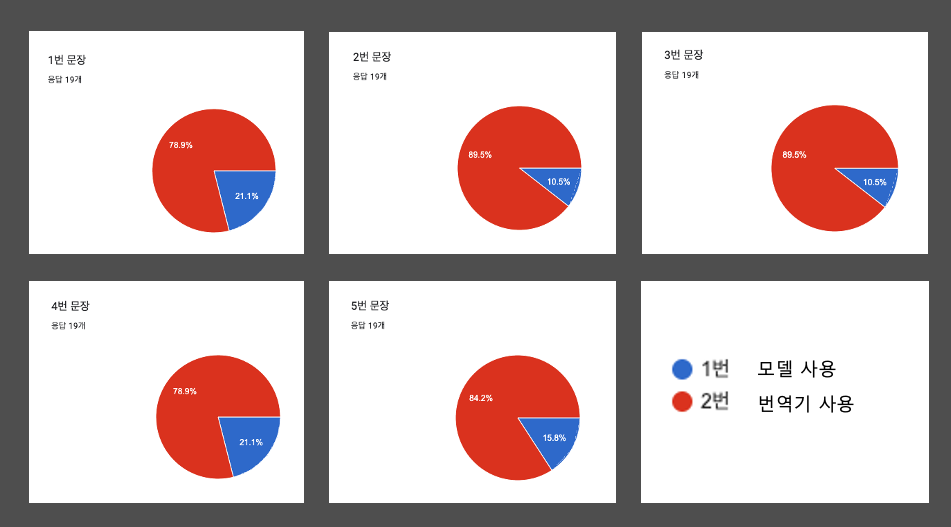